## FoodTrekker
### Final Project - Python for Developers - Group 10
#### Source code by - Arunabha Sen, Rohan Parikh, Venkatesh Bhattad


In [1]:
import os
import sys
import csv
import requests
import time
import pandas as pd
import numpy as np
import io, json
from bs4 import BeautifulSoup
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

Creating few global strings. These strings will be used throughour our project executions.

In [2]:
default_location = 'Pittsburgh'
location = default_location
saved_location = ''
filters = {}
yelp_url = 'https://api.yelp.com/v3/businesses/search'
yelp_api = 'cN5rYNCY5_xo17rpYiobB4zvkMfJg6P8myaszdQpkyh16Fo49_jFVSOIicwh2SB_MP7dUi_YvwnDpBHwMygewpfwAP-ucFytRt1d78iL_0ddLsgmE7LcpOsGfGNxWnYx'
zomato_url = 'https://developers.zomato.com/api/v2.1/'
zomato_api = '2a1c6f3bcec19c6ae981419cb5df1bc0'
reviewsCache = {}
rows = []

We believe in modularity in code. We broke down each task as a separate function. 
The docstrings in each functions is self explanatory of what the function is supposed to do.

In [3]:
def setup_file():
    """
    Create csv from the scraped data and return a panda dataframe.
    Parameters
    ----------
    Returns
    -------
    pd.DataFrame
        The panda dataframe of the scraped data
    """
    
    global saved_location
    # create and open file and writer
    ofile  = open('links.csv', "w", encoding='utf-8', newline='')
    wr = csv.writer(ofile, quoting=csv.QUOTE_ALL)
    
    # add the row for the columns
    wr.writerow(['Name', 'Address', 'City', 'Zip', 'lat', 'lon', 'Cuisines', 'Rating', 'Votes', 'Price', 'url'])
    # write row data
    [wr.writerow(row) for row in rows]
    ofile.close()
    
    # save the location of the recent search
    saved_location = location
    return pd.read_csv('links.csv')

In [4]:
def download_data():
    """
    Call the download method for each of the scraper, yelp and zomato or 
    return the same dataframe if the location does not change.
    Parameters
    ----------
    Returns
    -------
    pd.DataFrame
        The panda dataframe of the scraped data
    """
    
    # return the existing data if the location is the same
    if location == saved_location:
        return setup_file()
    r1 = download_yelp()
    r2 = download_zomato()

    # show error message if the scraping has failed
    if r1 != 200 and r2 != 200:
        print('--------------------------------')
        print('No results found')
        return None
    else:
        return setup_file()

In [5]:
def download_yelp():
    """
    Scrape the data for yelp.
    Parameters
    ----------
    Returns
    -------
    int
        The status code of the api request
    """
    
    global wr
    headers = {"authorization": 'Bearer %s' % yelp_api}
    params = {"location": location, "categories" : "restaurants"}
    try:
        response = requests.get(yelp_url, headers=headers, params=params)
    except:
        return None

    if response.status_code != 200:
        return response.status_code

    # the response data
    result = response.json()
    
    # the total number of restaurants
    total = result['total']

    # iterate for next set of results
    for i in range(0, total, 20):
        time.sleep(0.25)
        params = {"location": location, "categories" : "restaurants", "offset" : i}

        try:
            response = requests.get(yelp_url, headers=headers, params=params)
        except:
            return None
        
        result = response.json()
        if 'businesses' in result:
            for restaurant in result['businesses']:
                # create list with the necessary data
                content = []
                content.append(restaurant['name'])
                content.append(','.join(restaurant['location']['display_address']))
                content.append(str(restaurant['location']['city']))
                content.append(str(restaurant['location']['zip_code']))
                content.append(str(restaurant['coordinates']['latitude']))
                content.append(str(restaurant['coordinates']['longitude']))
                categories = restaurant['categories']
                c = []
                c.extend([ca['title'] for ca in categories])
                content.append(', '.join(c))
                content.append(str(restaurant['rating']))
                content.append(str(restaurant['review_count']))
                if 'price' not in restaurant:
                    price = ''
                else:
                    price = restaurant['price']
                content.append(price)
                content.append(restaurant['url'])
                rows.append(content)

    return response.status_code

In [6]:
def download_zomato():
    """
    Scrape the data for zomato.
    Parameters
    ----------
    Returns
    -------
    int
        The status code of the api request
    """ 
    
    global wr
    url = zomato_url + 'locations?query=' + location
    
    try:
        r = requests.get(url, headers={'user-key' : zomato_api})
    except:
        return None
    
    if r.status_code != 200:
        return r.status_code

    # the entity id for the location
    entity_id = r.json()['location_suggestions'][0]['entity_id']
    
    # the entity type for the location
    entity_type = r.json()['location_suggestions'][0]['entity_type']
    
    params = {"entity_id": entity_id, "entity_type" : entity_type, "start" : 0, 'sort' : 'rating', 'order' : 'desc'}

    try:
        r = requests.get(zomato_url + 'search', headers={'user-key' : zomato_api}, params=params)
    except:
        return None
    
    if r.status_code != 200:
        return r.status_code

    # the total number of restaurants
    total_count = r.json()['results_found']

    i = 0
    for i in range(0, 100, 20):
        url = zomato_url + 'search?entity_id=' + str(entity_id) + '&entity_type=' + str(entity_type) + '&start=' + str(i) + '&sort=rating&order=desc'
        try:
            r = requests.get(url, headers={'user-key' : zomato_api})
        except:
            return None
        time.sleep(0.2)
        write_data(r.json()['restaurants'])

    return r.status_code

In [7]:
def write_data(data):
    """
    Extract the response data from the json and create a row.
    Parameters
    ----------
    data
       The json data
    Returns
    -------
    """

    for json in data:
        j = json['restaurant']
        row = []
        row.append(j['name'])
        location = j['location']
        row.append(location['address'])
        row.append(location['city'])
        row.append(location['zipcode'])
        row.append(location['latitude'])
        row.append(location['longitude'])
        row.append(j['cuisines'])
        rating = j['user_rating']
        row.append(rating['aggregate_rating'])
        row.append(rating['votes'])
        row.append(''.join(['$'] * j['price_range']))
        row.append('')
        rows.append(row)

In [8]:
def show_filters():
    """
    Show the filters menu.
    Actions : Add filter, Price, Cuisine, Remove filter
    Parameters
    ----------
    Returns
    -------
    """
    
    global filters
    while True:
        # the filter menu
        print('============FILTERS MENU============')
        
        # print the selected filters
        if len(filters) == 0:
            print('Filters : NA')
        else:
            print('Filters : ')
            [print('Price : ' + ''.join(['$'] * filters[f])) for f in filters.keys() if f == 'price']
            [print('Cuisine : ' + filters[f]) for f in filters.keys() if f == 'cuisine']

        print('\n1. Price filter')
        print('2. Cuisine filter')
        print('3. Remove all')
        print('0. Main menu')
        option = input('\nPlease select an option : ')

        if option.lower() == '1':
            c = show_filters_price()
            if not c is None:
                filters['price'] = c
        elif option.lower() == '2':
            c = input('Enter cuisine (0 for all) : ')
            if c != '0':
                filters['cuisine'] = c
            else:
                filters.pop('cuisine')
        elif option.lower() == '3':
            filters = {}
        elif option.lower() == '0':
            break
        else:
            print('--------------------------------')
            print('Incorrect option')

In [9]:
def show_filters_price():
    """
    Show the price filters menu.
    Actions : $, $$, $$$, $$$$, $$$$$, all
    Parameters
    ----------
    Returns
    -------
    """
    
    global filters
    while True:
        # the price filter menu
        print('============PRICE FILTERS MENU============')

        print('\n1. $')
        print('2. $$')
        print('3. $$$')
        print('4. $$$$')
        print('5. $$$$$')
        print('6. All')
        print('0. Filters menu')
        option = input('\nPlease select an option : ')

        if option.lower() == '1':
            return 1
        elif option.lower() == '2':
            return 2
        elif option.lower() == '3':
            return 3
        elif option.lower() == '4':
            return 4
        elif option.lower() == '5':
            return 5
        elif option.lower() == '6':
            filters.pop('price')
            break
        elif option.lower() == '0':
            break
        else:
            print('--------------------------------')
            print('Incorrect option')

In [10]:
def filter_dataframe(df):
    """
    Filter the dataframe and remove unnecessary data.
    Parameters
    ----------
    df
       The dataframe to filter
    Returns
    -------
    pd.DataFrame
       The filtered dataframe
    """
    
    # create score column using the rating and votes
    df['score'] = df.Rating * df.Votes
    
    # remove incorrect rows
    filtered_df = df.dropna()
    
    # filter the dataframe on the filters set
    if 'price' in filters:
        price = ''.join(['$'] * filters['price'])
        filtered_df = filtered_df[filtered_df.Price == price]
    if 'cuisine' in filters:
        filtered_df = filtered_df[filtered_df.Cuisines.str.contains(filters['cuisine'], case=False)]
        
    # sort on the score column    
    filtered_df.sort_values('score', inplace = True, ascending = False)
    filtered_df.reset_index(inplace = True)
    filtered_df.drop('index', axis = 1, inplace = True)
    return filtered_df

In [11]:
def retrieve_html(url):
    """
    Retrieves the html page content of the given url. Returns the status code and text as the output.
    Parameters
    ----------
    url
       The restaurant url
    Returns
    -------
    int
       The status code
    """
    
    response = requests.get(url)
    return (response.status_code, response.text)

In [12]:
def parse_page(html):
    """
    Parses the html page content of the restaurant. Returns the reviews and url for the next page.
    Parameters.
    This function is to demonstrate the working of web-scraping.
    ----------
    html
       The html response for the restaurant url
    Returns
    -------
    (reviews, next_url)
       The list with the review data
       The url for the next page
    """
    
    soup = BeautifulSoup(html, 'html.parser') 
    mydivs = soup.find_all("div", class_ = "review review--with-sidebar")
    reviews = []
    for div in mydivs:
        d = {}
        d['rating'] = round(float(div.find("img", class_ = "offscreen")['alt'].strip()[:3]),1)
        date = div.find("span", class_ = "rating-qualifier").get_text().strip()[:10].strip().split('/')
        d['text'] = str(div.find("p").get_text().strip())
        reviews.append(d)    
    next_url = soup.find("a", class_ = "u-decoration-none next pagination-links_anchor")
    if next_url is not None:
        next_url = next_url.get('href')
    return (reviews, next_url)

In [13]:
def extract_reviews(url):
    """
    Extracts all reviews of a given restaurant url link.
    Parameters
    ----------
    url
       The html response for the restaurant url
    Returns
    -------
    list
       The list with the review data
    """
    # If the URL was already scraped, then return from cache. Else scrape.
    if url in reviewsCache:
        return reviewsCache[url]
    
    reviews = [] 
    i = 0
    html_text = retrieve_html(url)[1]
    parsed_text = parse_page(html_text)
    reviews.extend(parsed_text[0])
    next_url = parsed_text[1]
    while next_url is not None:
        i += 1
        time.sleep(0.25)
        html_text = retrieve_html(next_url)[1]
        parsed_text = parse_page(html_text)
        reviews.extend(parsed_text[0])
        next_url = parsed_text[1]
    reviewsCache[url] = reviews
    return reviews

In [14]:
def getWordCloudAndRestaurantSummary(data):
    """
    Create a wordcloud using the user reviews of a restaurant.
    Parameters
    ----------
    data
       The list with the review data
    Returns
    -------
    list, list
       The list with the wordcloud data
       The list with the output data
    """
    
    wordCloud = []
    output = []
    for review in data[:5]:
        wordCloud.append(review['text'])
        text = review['text']
        polarity = TextBlob(text).sentiment[0]
        if polarity >=-0.2 and polarity <=0.2:
            sentiment = 'Neutral'
        elif polarity > 0.2:
            sentiment = 'Positive'
        else:
            sentiment = 'Negative'
        summary = []
        summary.append(review['rating'])
        summary.append(review['text'])
        summary.append(polarity)
        summary.append(sentiment)
        output.append(summary)
    return (wordCloud, output)

In [15]:
def generateWordCloud(reviewText):
    """
    The objective of this method is to generate a wordcloud of the given text.
    Generating a word cloud could provide us an idea on what would be the most talked about word about the restaurant.
    Parameters
    ----------
    data
       The review data
    Returns
    -------
    """
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(reviewText)
    # Generating a figure of size 32 X 24
    fig = plt.figure(figsize=(32,24))
    ax = fig.add_subplot(111)

    # Display the generated image using the matplotlib library
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_aspect(1)
    # Since this is a word cloud, we donot need any axis.
    plt.axis("off")
    plt.show()

In [16]:
def plotRestaurantReviews(reviewRatings):
    """
    The objective of this method is to generate a plot of the restaurant ratings.
    Generating a ratings plot would show the distribution of the ratings.
    Parameters
    ----------
    reviewRatings
       The ratings data
    Returns
    -------
    """
    
    fig, ax = plt.subplots()
    # Get n, mu, sigma, median.
    n = len(reviewRatings)
    mu = reviewRatings.mean()
    sigma = reviewRatings.std()
    median = np.median(reviewRatings)
    # Plot the histogram
    plt.hist(x=reviewRatings, edgecolor = 'black')
    plt.axvline(median, color='b', linestyle='dashed', linewidth=2)
    plt.xticks([1,2,3,4,5])
    plt.xlabel("Rating")
    plt.ylabel("Count of Ratings")
    plt.title("Histogram of Review Ratings")
    ax.legend(['n = %d,\n$\mathrm{}\mu=%.3f, \sigma=%.3f$, \nmedian = %d' %(n, mu, sigma, median)],\
                        fancybox = True, shadow = True, handlelength=0,)
    plt.show()

In [24]:
def analyseSentiment(sentiments):
    """
    The objective of this method is to generate a sentiment score of the restaurant.
    Parameters
    ----------
    sentiments
       The restaurant data
    Returns
    -------
    """
    # Caluculate the mean of the sentiment. Print image based on average.
    avg_sentiment = sentiments.mean()
    if(avg_sentiment > 0.2):
        img = Image.open('../images/happy.png', 'r')
    elif(avg_sentiment < -0.4):
        img = Image.open('../images/sad.png', 'r')
    else:
        img = Image.open('../images/neutral.png', 'r')
    # Show the image.
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()

In [18]:
def getTopCuisines(df):
    groups = df.groupby('Cuisines').count()
    groups.sort_values('Name', inplace = True, ascending = False)
    to_print = pd.DataFrame(groups.index[:3])
    display(HTML(to_print.to_html()))

### This is the main driver function to our application. This method executes as following.

1. Display a Menu with a default filter. (Default filter - location : Pittsburgh)
2. Ask for user input for the following:
   * Change location
   * Change filter
   * Search with current filter (Default will be last searched)
   * Quit.
3. If the user selects option 1. (location)
4. If the user selects option 2. (updating filter)
    * Diplay the filter menu
        * Add / Modify price filter
        * Add / Modify cuisine filter
        * Removing all filters
        * Returning to main menu.
5. If the user selects option 3. (Search)
    * Searches with the current filter.
        * looks into the current dataframe if the location is same or changed.
        * If the location is changed - (will run the first time the program loads always)
            * Scrapes new restaurants and updates the dataframe.
            * Downloads data using REST api for Yelp and Zomato and stores them in a CSV.
        * Updates the data by filtering rows if there is any filter present.
    * Display few basic analytics for the current location.
        * Displays the review / rating distribution
        * Display the top 3 cuisines.
    * Display our recommended restaurant by sorting the data in descending order of score. (score is calculcated as factor of votes and reviews.
    * Ask the user to select a input / restaurant for highlights and analytics on the review selected.
        * See if the reviews are already scraped for the restaurant in cache.
        * If present then display, histogram of review rating, word cloud and sentiment score.
        * else, scrape reviews of that restaurant and store in cache.
6. Quit

In [22]:
def show_menu():
    """
    Show the main menu.
    Actions : Change location, Add filter, Search
    Parameters
    ----------
    Returns
    -------
    """
    
    global location
    global filters

    while True:
        print('============MENU============')
        print('Location : ' + location)
        if len(filters) == 0:
            print('Filters : NA')
        else:
            print('Filters : ')
            [print('Price : ' + ''.join(['$'] * filters[f])) for f in filters.keys() if f == 'price']
            [print('Cuisine : ' + filters[f]) for f in filters.keys() if f == 'cuisine']

        print('\n1. Change location')
        print('2. Add filter')
        print('3. Search')
        print('q. Quit')
        option = input('\nPlease select an option : ')

        if option.lower() == '1':
            location = input('Enter new location : ')
        elif option.lower() == '2':
            show_filters()
        elif option.lower() == '3':
            print('--------------------------------')
            print('Searching data .......')
            df = download_data()
            print("There were %d restaurants found with the current filter" % (len(df)))
            # Plot general stats
            # Plot histogram of review of that particular rating.
            print("Plot of all restaurant ratings")
            plotRestaurantReviews(df.Rating)
            # Get top 3 cuisines.
            print("Top three cuisines")
            getTopCuisines(df)
            # Filter the dataframe based on the filter(s) applied.
            filtered_df = filter_dataframe(df)
            if(len(filtered_df) > 1):
                # Generate a dataframe to print the top 5 restaurants.
                to_print_df = filtered_df[['Name', "Address","Rating","Price", 'score']].head()
                # Print the dataframe.
                display(HTML(to_print_df.to_html()))
                # Since the df is sorted by score. Print our recommended restaurant.
                to_print = pd.DataFrame(to_print_df.iloc[0])
                to_print.columns = ['Our Recommendation']
                display(HTML(to_print.to_html()))
                # Ask the user for input to choose the restaurant.
                choice = int(input('Select a restaurant from the above tabel to get highlights (-1 for main menu / 0 for our recommendation) : '))
            else:
                print("No restaurants available with the current filter. Try a different search")
                choice = -1
            if choice != -1:
                # If the choice entered was greater than the length of the df. then print our recommendation
                if(choice > len(filtered_df)):
                    choice = 0
                # Making sure the search filters returned some restaurants.
                if(len(filtered_df) > 1):
                    # Extract URL to extract reviews.
                    url = filtered_df.url[choice]
                    print("Extracting Reviews...")
                    # Get all reviews
                    data = extract_reviews(url)
                    # Pass the text to get the wordcloud and summary of data.
                    wordCloud, output = getWordCloudAndRestaurantSummary(data)
                    print("Generating WordCloud...")
                    # Generate Word Cloud.
                    generateWordCloud("\n".join(wordCloud))
                    # Generate the reviews dataframe
                    reviews_dataframe = pd.DataFrame(output)
                    reviews_dataframe.columns = ["rating", "review_text", "sentiment", "sentiment_desc"]
                    print("Plotting Restaurant Reviews...")
                    # Plot histogram of review of that particular rating.
                    plotRestaurantReviews(reviews_dataframe.rating)
                    print("Analysing sentiment from the reviews...")
                    # Print the analysed sentiment.
                    analyseSentiment(reviews_dataframe.sentiment)
                else:
                    print("No restaurants available!")
        elif option.lower() == 'q':
            break
        else:
            print('Incorrect option')

Making the cells below this cell non-scrollable.

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

============MENU============
Location : Pittsburgh
Filters : NA

1. Change location
2. Add filter
3. Search
q. Quit

Please select an option : 3
--------------------------------
Searching data .......
There were 1100 restaurants found in Pittsburgh location
Plot of all restaurant ratings


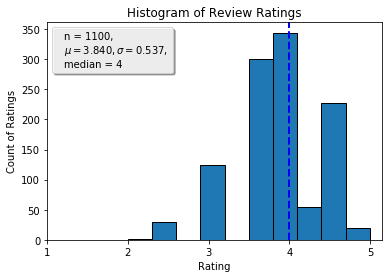

Top three cuisines


,Cuisines
0,Pizza
1,Chinese
2,Thai


,Name,Address,Rating,Price,score
0,Gaucho Parrilla Argentina,"1601 Penn Ave,Pittsburgh, PA 15222",4.5,$$,6147.0
1,Meat & Potatoes,"649 Penn Ave,Pittsburgh, PA 15222",4.0,$$$,6104.0
2,Noodlehead,"242 S Highland Ave,Pittsburgh, PA 15206",4.5,$,3982.5
3,Primanti Bros.,"46 18th St,Pittsburgh, PA 15222",3.5,$,3934.0
4,täkō,"214 6th St,Pittsburgh, PA 15222",4.5,$$,3915.0


,Our Recommendation
Name,Gaucho Parrilla Argentina
Address,"1601 Penn Ave,Pittsburgh, PA 15222"
Rating,4.5
Price,$$
score,6147


Select a restaurant from the above tabel to get highlights (-1 for main menu / 0 for our recommendation) : 10
Extracting Reviews...
Generating WordCloud...


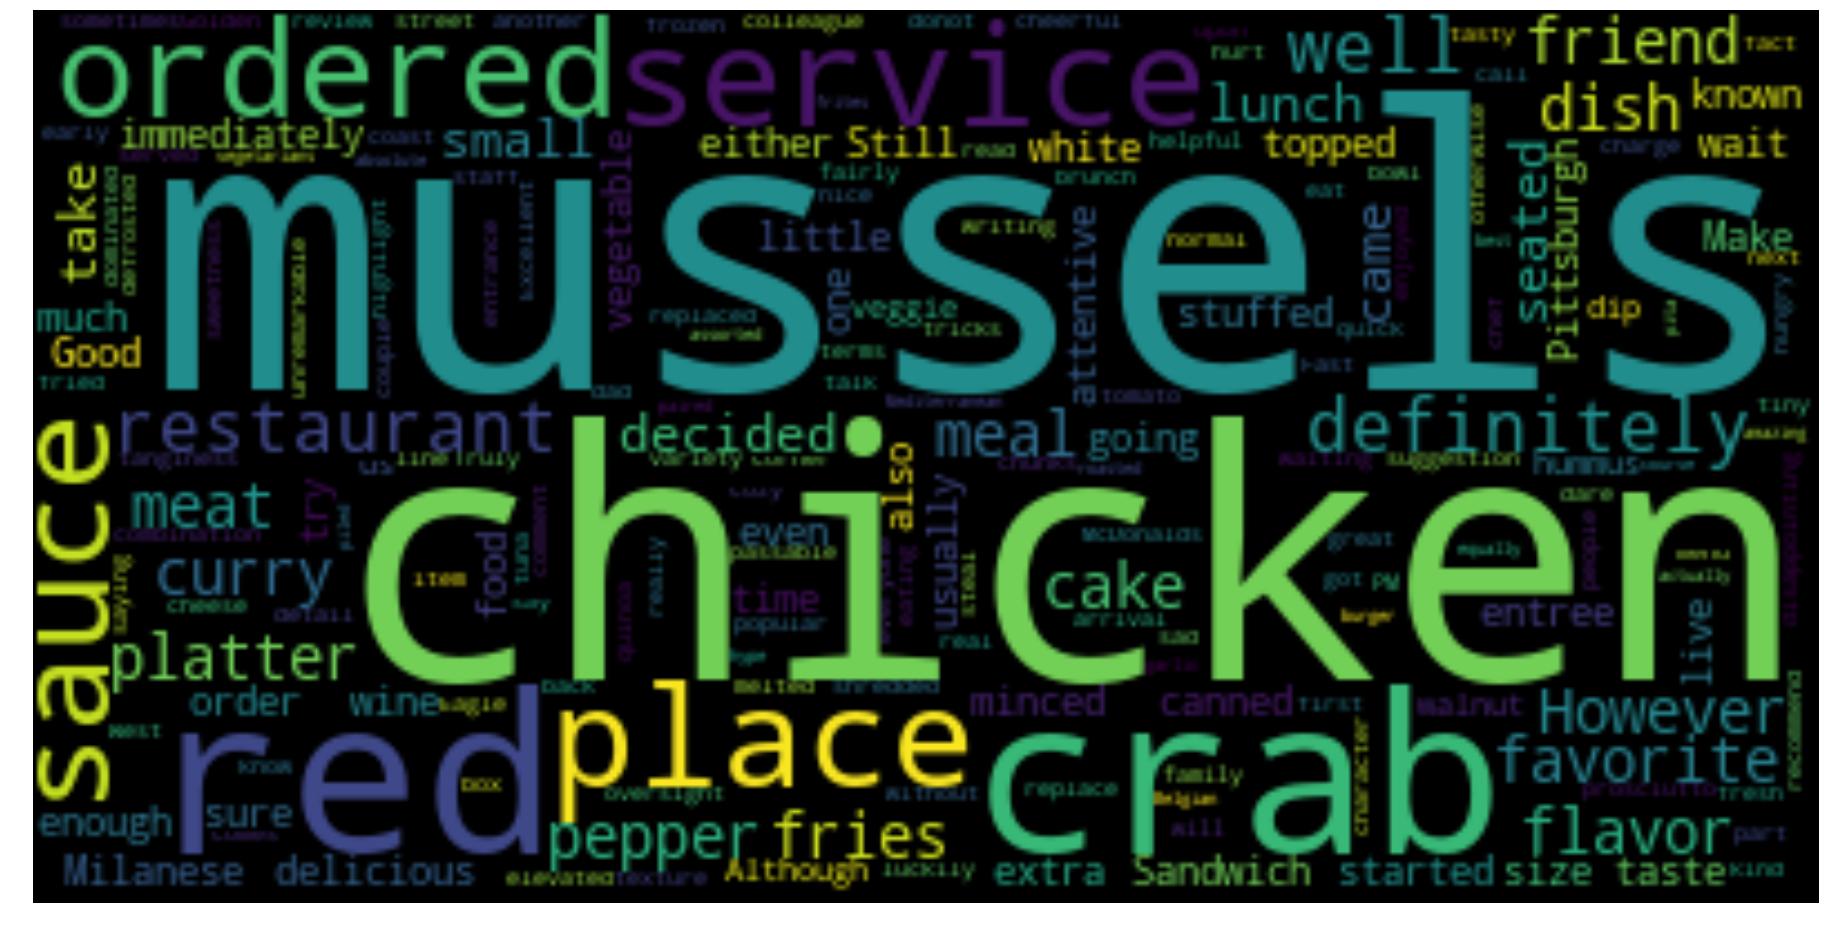

Plotting Restaurant Reviews...


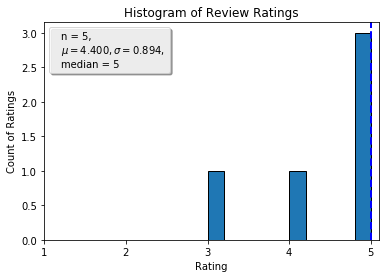

Analysing sentiment from the reviews...


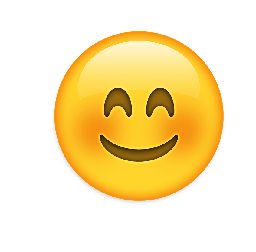

============MENU============
Location : Pittsburgh
Filters : NA

1. Change location
2. Add filter
3. Search
q. Quit

Please select an option : q


In [25]:
show_menu()